# Standard LSTM for Sequence Classification

This is the standard LSTM that the iBCM - LSTM combination will be benchmarked against.

In [1]:
# Import libraries
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
from keras.layers import LSTM, Dense,Dropout, Embedding
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import random
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score
import time


Using TensorFlow backend.


In [2]:
# Define functions

def load_sequences(name,path):
    trace_file = open(path+'\\'+name+'.dat', 'r')
    label_file = open(path+'\\'+name+'.lab', 'r')
    
    traces = []
    label_list = []
    labels = set()
    for trace, label in zip(trace_file, label_file):
        traces.append(trace)
        label_list.append(label.replace('\n',''))
        labels.add(label.replace('\n',''))
    
    final_traces = []
    for trace in traces:
        trace = trace.replace('\n', '')
        trace = trace.replace(' -1 -2', '')
        acts = trace.split(' -1 ')
        final_traces.append(acts)        
            
    df = pd.DataFrame({'Trace':final_traces, 'Label': label_list})
    return df

def one_hot_encode(sequence):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique_items+1)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [3]:
#Load Data
#Choose file and set path here!!
name = 'context'
path = 'D:\Studies\Dissertation\iBCM\iBCM-Master\iBCM-master\python'
df = load_sequences(name,path)

In [4]:
start = time.time()

traces = df.Trace

trace_int = []
trace_set = set()
for x in traces:
    trace_int.append([int(y) for y in x])
    trace_set = trace_set.union(x)
    
new_df = pd.DataFrame({'Trace':trace_int,'Label':list(df.Label)})
new_df.head(10)

n_unique_items = len(trace_set)
maxlen = max([len(x) for x in df.Trace])

#padded_trace = sequence.pad_sequences(trace_int,maxlen = maxlen, padding = 'post')
#Pre-padding
padded_trace = sequence.pad_sequences(trace_int,maxlen = maxlen)
padded_trace = padded_trace.tolist()

end = time.time()

print('Time for dataset creation is ',round(end-start),' seconds')

Time for dataset creation is  0  seconds


In [5]:
pre_encode_label = list(df.Label).copy()
LEnc = LabelEncoder()
encoded_labels = LEnc.fit_transform(pre_encode_label)

OHE = OneHotEncoder(dtype=int,sparse=False)
enc = np.array(pre_encode_label).reshape(len(pre_encode_label),1)
OHELabels = OHE.fit_transform(enc)

dataframe  = pd.DataFrame({'Trace':padded_trace, 'Label':[int(x) for x in encoded_labels]})

train, test = train_test_split(dataframe, test_size = 0.10)

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
train_traces = train['Trace']
train_labels = train['Label']

test_traces = np.array(test['Trace'])
test_labels = np.array(test['Label'])

y_train = np.stack(train_labels)
y_test  = np.stack(test_labels)

x_train = np.stack(train_traces)
x_test = np.stack(test_traces)

print("Shape of Y_Train : ", y_train.shape)
print("Shape of Y_Test : ", y_test.shape)

num_lab = len(set(dataframe.Label))

print("\nShape of X_train : ",x_train.shape)
print("Shape of X_test : ",x_test.shape)

Shape of Y_Train :  (216,)
Shape of Y_Test :  (24,)

Shape of X_train :  (216, 246)
Shape of X_test :  (24, 246)


In [7]:
start = time.time()

#Hyperparameters
time_steps = maxlen
n_dim = 1
batch_size = 1
n_epochs = 50
max_features = 2000
cells = 32
num_lab = len(set(dataframe.Label))+1

results_dataframe_2 = pd.DataFrame(columns = [
                             'Accuracy',
                             'Loss Score',
                             'Train size',
                             'Model_time','Macro Precision','Micro Precision','Macro Recall','Micro Recall',
                                              'Macro f1','Micro f1','Macro AUC',
                                                         'Micro AUC',
                                                         'Weighted AUC'])

model = Sequential()
model.add(Embedding(max_features, cells))
model.add(LSTM(cells, dropout=0.2, recurrent_dropout=0.2,return_sequences = False))
model.add(Dense(num_lab,activation = 'softmax'))
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "nadam", metrics = ['accuracy'])
history = model.fit(x_train, y_train,epochs=n_epochs, validation_data=(x_test, y_test))

end = time.time()
exec_time = round(end - start,3)
print('Time for training the model = ',exec_time,' seconds')

evaluation = model.evaluate(x_test, y_test)
print('Test score:', evaluation[0])
print('Test accuracy:', evaluation[1])


yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_test, verbose=0)

accuracy = accuracy_score(y_test, yhat_classes)
# precision tp / (tp + fp)
macro_precision = precision_score(y_test, yhat_classes,average='macro')
micro_precision = precision_score(y_test, yhat_classes,average='micro')
macro_recall = recall_score(y_test, yhat_classes,average='macro')
micro_recall = recall_score(y_test, yhat_classes,average='micro')

macro_f1 = f1_score(y_test, yhat_classes, average='macro')
micro_f1 = f1_score(y_test, yhat_classes, average='micro')
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
bin_lab_test = lb.transform(y_test)
bin_lab_pred = lb.transform(yhat_classes)

macro_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'macro')
micro_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'micro')
weighted_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'weighted')

results_dataframe_2 = results_dataframe_2.append({'Accuracy':evaluation[1],
                                                 'Loss Score':evaluation[0],
                                                 'Train size':x_train.size,
                                                 'Model_time':exec_time,
                                                 'Macro Precision':macro_precision,
                                                 'Micro Precision':micro_precision,
                                                 'Macro Recall':macro_recall,
                                                'Micro Recall':micro_recall,
                                                 'Macro f1':macro_f1,
                                                 'Micro f1':micro_f1,
                                                 'Macro AUC':macro_auc,
                                                 'Micro AUC':micro_auc,
                                                 'Weighted AUC':weighted_auc},ignore_index=True)

W0821 20:41:35.661411 26536 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 20:41:35.678351 26536 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 20:41:35.680349 26536 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 20:41:35.737185 26536 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 72,518
Trainable params: 72,518
Non-trainable params: 0
_________________________________________________________________
Train on 216 samples, validate on 24 samples
Epoch 1/50
216/216 [==============================] - 2s 8ms/step - loss: 1.7820 - acc: 0.2361 - val_loss: 1.7675 - val_acc: 0.0417
Epoch 2/50
216/216 [==============================] - 1s 4ms/step - loss: 1.7345 - acc: 0.2269 - val_loss: 1.7139 - val_acc: 0.0417
Epoch 3/50
216/216 [==============================] - 1s 4ms/step - loss: 1.6541 - acc: 0.213

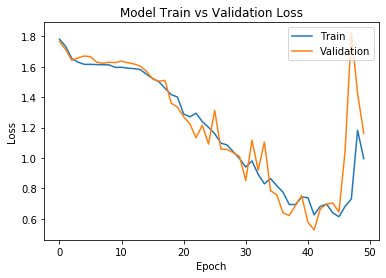

In [8]:
#Plot training vs validation loss
%matplotlib inline
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

(0, 5)

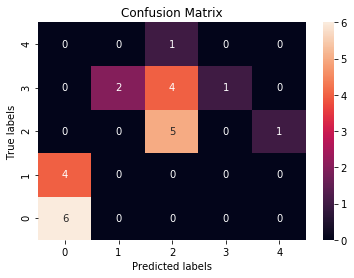

In [9]:
#Plot confusion matrix
#%matplotlib inline
import seaborn as sn
from matplotlib import pyplot as plt
ax = plt.subplot()
cm = confusion_matrix(y_test,yhat_classes)
cm_df = pd.DataFrame(cm)
#sn.set(font_scale=1) #for label size
sn.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

ax.set_ylim(0,num_lab-1)